## Generating Representations and Contact Maps Using the Protein Language Model ESM-2

In [1]:
#1. set up ESM-2 protein language model 
#2. process input data (FASTA files)
#3. carry out basic transformation with model: feed as input the protein sequences, and display output - what actually is the output? 
# %pip install torch
# %pip install matplotlib

In [1]:
#1. Set up ESM-2 Protein Language Model
import torch

In [2]:
# Source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Using cache found in C:\Users\aguba/.cache\torch\hub\facebookresearch_esm_main


In [4]:
batch_converter = alphabet.get_batch_converter()
# model.eval() 

In [5]:
#2. Process input data (FASTA files)
%run utils.ipynb

In [6]:
#folder_path = "protein_sequences_short" # my CPU capacity is insufficient to proccess all at once
#all_data,lengths = process_fasta_files(folder_path)
folder_path = "uniprot_sequences"
all_data,lengths = process_uniprot_folder(folder_path)
data = [(protein[0],protein[1]) for protein in all_data] # get id and sequence only

In [7]:
# Tokenizing sequences, with padding 
batch_labels, batch_strs, batch_tokens = batch_converter(data)
print(f"Labels: {batch_labels}")
#print(f"Sequences: {batch_strs}")
print(f"Shape of tensor where each sequence is a vector of token IDs: {batch_tokens.shape}")
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
print(f"Lenght of each sequence vector w/o padding: {batch_lens}")
print(batch_tokens)

Labels: ['P01116', 'P31749']
Shape of tensor where each sequence is a vector of token IDs: torch.Size([2, 482])
Lenght of each sequence vector w/o padding: tensor([191, 482])
tensor([[ 0, 20, 11,  9, 19, 15,  4,  7,  7,  7,  6,  5,  6,  6,  7,  6, 15,  8,
          5,  4, 11, 12, 16,  4, 12, 16, 17, 21, 18,  7, 13,  9, 19, 13, 14, 11,
         12,  9, 13,  8, 19, 10, 15, 16,  7,  7, 12, 13,  6,  9, 11, 23,  4,  4,
         13, 12,  4, 13, 11,  5,  6, 16,  9,  9, 19,  8,  5, 20, 10, 13, 16, 19,
         20, 10, 11,  6,  9,  6, 18,  4, 23,  7, 18,  5, 12, 17, 17, 11, 15,  8,
         18,  9, 13, 12, 21, 21, 19, 10,  9, 16, 12, 15, 10,  7, 15, 13,  8,  9,
         13,  7, 14, 20,  7,  4,  7,  6, 17, 15, 23, 13,  4, 14,  8, 10, 11,  7,
         13, 11, 15, 16,  5, 16, 13,  4,  5, 10,  8, 19,  6, 12, 14, 18, 12,  9,
         11,  8,  5, 15, 11, 10, 16, 10,  7,  9, 13,  5, 18, 19, 11,  4,  7, 10,
          9, 12, 10, 16, 19, 10,  4, 15, 15, 12,  8, 15,  9,  9, 15, 11, 14,  6,
         23,  7

### Generating Token Representations from ESM-2
Per-residue representations are generated from the model. This means that each amino acid (ie residue) in each sequence is converted to a context vector (ie embedding) by the model. As such, each amino acid is then represented by n vectors, where n is the number of amino acids in its sequence. These vectors can be used to analyse each individual amino acid.

Contact maps are also produced which show which amino acids are spatially close in the 3D protein structure. They are predicted in ESM-2 using logistic regression over the model's attention maps (an unsupervised method). From the codebase, ContactPredictionHead takes in the tokens and attentions and "performs symmetrization, apc, and computes a logistic regression on the output features". 
See code for ContactPredictionHead at https://github.com/facebookresearch/esm/blob/main/esm/modules.py. 

In [8]:
#3. carry out basic transformation with model
# source: https://github.com/facebookresearch/esm/tree/main?tab=readme-ov-file#esmfold

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]
print(f"Embedding of 1st amino acid in protein {batch_labels[0]}: {token_representations[0]}")

# Generate per-sequence representations via averaging - used to analyse the protein as a whole
# For each sequence, padding is removed and the average of the remaining embeddingsis taken
sequence_representations = [] 
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))
print(f"Vector of protein {batch_labels[0]}: {sequence_representations[0]}")

Embedding of 1st amino acid in protein P01116: tensor([[ 0.0645,  0.0474,  0.0932,  ..., -0.2755,  0.1775,  0.0530],
        [ 0.0661,  0.1000, -0.1732,  ...,  0.1509, -0.1093,  0.1269],
        [-0.1258,  0.5283, -0.0024,  ...,  0.3402,  0.1909,  0.0747],
        ...,
        [ 0.1034,  0.2692,  0.1639,  ..., -0.0120, -0.2076, -0.0082],
        [ 0.0951,  0.2752, -0.0090,  ..., -0.1978, -0.2075, -0.3849],
        [ 0.1146,  0.2335,  0.1324,  ..., -0.0960, -0.2730, -0.2380]])
Vector of protein P01116: tensor([ 0.0207,  0.0024, -0.1124,  ..., -0.2298,  0.0804,  0.1373])


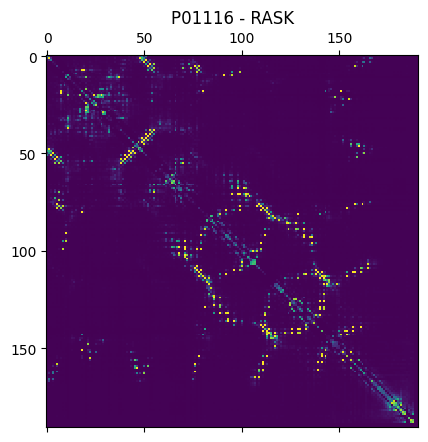

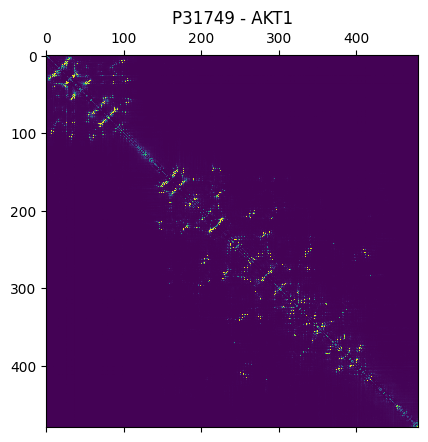

In [9]:
# Look at the unsupervised self-attention map contact predictions
# Produced when extracting per residue representations from model
import matplotlib.pyplot as plt
for (id, seq, name), tokens_len, attention_contacts in zip(all_data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(f"{id} - {name}")
    plt.show()